### softmax_mobile

##### Train


In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pandas as pd
import numpy as np


import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [22]:
df = pd.read_csv('移动设备-data/train.csv')
with open("mobileCfg.json", "r", encoding="utf-8") as f:
        cfg = json.load(f)
print("cfg:",cfg)


features = df.iloc[:, :-1] # 特征
features = torch.tensor(features.values,dtype=torch.float32)

labels = df.iloc[:,-1]  # 标签
labels = torch.tensor(labels,dtype=torch.float32)



# #归一化
# # 特征和标签归一化
features_tensor = torch.tensor(df.iloc[:, :-1].values, dtype=torch.float32)
labels_tensor = torch.tensor(df.iloc[:, -1].values, dtype=torch.float32)

# # 计算归一化参数
feature_min = features_tensor.min(dim=0).values
feature_max = features_tensor.max(dim=0).values

# # 应用归一化
features = (features_tensor - feature_min) / (feature_max - feature_min + 1e-8)
# labels = labels.view(-1, 1)  # 确保形状为 [n_samples, 1]


class mobileDataset(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
batch_Size = int(cfg['batch_Size'])  #32

dataset = mobileDataset(features, labels)
train_loader = DataLoader(dataset, batch_size=batch_Size, shuffle=True)


cfg: {'batch_Size': '32', 'epochs': '300', 'lr': '0.001', 'input_size': '20', 'hidden_size': '16', 'output_size': '4', 'patience': '20'}


In [23]:
class MobileModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MobileModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [24]:
model = MobileModel(input_size=features.shape[1], hidden_size=int(cfg['hidden_size']), output_size=int(cfg['output_size'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=float(cfg['lr']))

epochs = int(cfg['epochs'])
best_loss = float('inf')

counter = 0

train_loss_history = []

for epoch in range(epochs):
    epoch_loss = 0.0
    model.train()

    for i ,(features, labels) in enumerate(train_loader):
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                epoch+1, epochs, i+1, len(train_loader), loss.item()))
    avg_loss = epoch_loss / len(train_loader)
    train_loss_history.append(avg_loss)

     # 保存最佳模型
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'loss': avg_loss
        }, 'best_model.pth')
    else:
        counter += 1
        if counter >= int(cfg["patience"]):
            print("Early stopping triggered")
            break
    
    # 打印每个epoch的平均损失
    print(f'Epoch {epoch+1} Average Loss: {avg_loss:.4f}')

print('Finished Training!')



Epoch [1/300], Step [10/63], Loss: 1.3964
Epoch [1/300], Step [20/63], Loss: 1.3696
Epoch [1/300], Step [30/63], Loss: 1.3761
Epoch [1/300], Step [40/63], Loss: 1.3491
Epoch [1/300], Step [50/63], Loss: 1.3787
Epoch [1/300], Step [60/63], Loss: 1.3723
Epoch 1 Average Loss: 1.3831
Epoch [2/300], Step [10/63], Loss: 1.3653
Epoch [2/300], Step [20/63], Loss: 1.3580
Epoch [2/300], Step [30/63], Loss: 1.3265
Epoch [2/300], Step [40/63], Loss: 1.3663
Epoch [2/300], Step [50/63], Loss: 1.3486
Epoch [2/300], Step [60/63], Loss: 1.3347
Epoch 2 Average Loss: 1.3502
Epoch [3/300], Step [10/63], Loss: 1.3124
Epoch [3/300], Step [20/63], Loss: 1.3116
Epoch [3/300], Step [30/63], Loss: 1.2976
Epoch [3/300], Step [40/63], Loss: 1.3048
Epoch [3/300], Step [50/63], Loss: 1.2675
Epoch [3/300], Step [60/63], Loss: 1.2908
Epoch 3 Average Loss: 1.2977
Epoch [4/300], Step [10/63], Loss: 1.2707
Epoch [4/300], Step [20/63], Loss: 1.2077
Epoch [4/300], Step [30/63], Loss: 1.2368
Epoch [4/300], Step [40/63], Lo

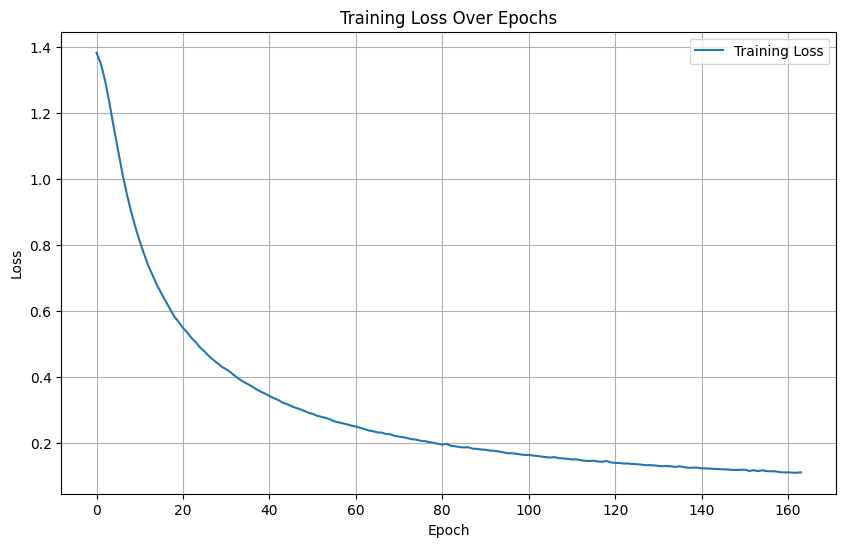

In [25]:
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_loss.png')

### test

In [ ]:
model_test = MobileModel(input_size=features.shape[1], hidden_size=int(cfg['hidden_size']), output_size=int(cfg['output_size'])).to(device)

model_test.load_state_dict(torch.load('best_model.pth')['model_state_dict'])
model_test.eval()



df = pd.read_csv('移动设备-data/train.csv')


features_test = df.iloc[:, :-1] # 特征
features_test = torch.tensor(features_test.values,dtype=torch.float32)

labels_test = df.iloc[:,-1]  # 标签
labels_test = torch.tensor(labels_test,dtype=torch.float32)


print(features_test.shape)
print(labels_test.shape)


# #归一化
# # 特征和标签归一化
features_test_tensor = torch.tensor(df.iloc[:, :-1].values, dtype=torch.float32)
labels_test_tensor = torch.tensor(df.iloc[:, -1].values, dtype=torch.float32)

# # 计算归一化参数
feature_min = features_test_tensor.min(dim=0).values
feature_max = features_test_tensor.max(dim=0).values

# # 应用归一化
features_test = (features_test_tensor - feature_min) / (feature_max - feature_min + 1e-8)
# labels = labels.view(-1, 1)  # 确保形状为 [n_samples, 1]

dataset_test = mobileDataset(features_test, labels_test)



test_loader = DataLoader(dataset_test, batch_size=batch_Size, shuffle=True)


correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_test(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
acc = 100 * correct / total


print(f'Test Accuracy: {acc:.2f}%')



tensor([1., 2., 2.,  ..., 3., 0., 3.])
torch.Size([2000, 20])
torch.Size([2000])
Test Accuracy: 98.40%
